# Moving Averages CINGULATE region

### 1) Imports

In [1]:
import os
import glob
import sys

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [2]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

from datasets import SkeletonDataset
import torch
from vae import *

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn import metrics

import matplotlib.cm as cm

In [3]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [4]:
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

### 2) Loading of subjects's distribution in the latent space
DataFrame is obtained during analysis of beta-VAE latent space (2 dimensions) for CINGULATE crops, according to the following steps:
- loading of trained model
- encoding of test controls and asymmetry benchmark subjects

In [5]:
if torch.cuda.is_available():
    device = "cuda:0"

In [6]:
model_dir = '/neurospin/dico/lguillon/midl_22/new_design/gridsearch/n_4_kl_2/'
model = VAE((1, 20, 40, 40), 4, depth=3)
model.load_state_dict(torch.load(model_dir + 'checkpoint.pt'))
model = model.to(device)

In [7]:
subject_dir = "/neurospin/dico/data/deep_folding/current/"
data_dir = "/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/"

train_list = pd.read_csv(os.path.join(subject_dir,
                         f"HCP_half_{1}bis.csv"), header=None,
                         usecols=[0], names=['subjects'])

train_list['subjects'] = train_list['subjects'].astype('str')

tmp = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')

tmp = tmp.merge(train_list, left_on = tmp.index, right_on='subjects', how='right')

filenames = list(train_list['subjects'])

subset = SkeletonDataset(dataframe=tmp, filenames=filenames)

In [8]:
dataloader = torch.utils.data.DataLoader(
              subset,
              batch_size=64,
              num_workers=8,
              shuffle=True)    

In [9]:
dico_set_loaders = {'data': dataloader}

root_dir = '/neurospin/dico/lguillon/midl_22/new_design/analysis/n_4_kl_2/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=4, depth=3, root_dir=root_dir)

In [10]:
results = tester.test()
encoded = {loader_name:[results[loader_name][k] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded['data']
X = np.array(list(df_encoded['latent']))
labels = list(results['data'].keys())

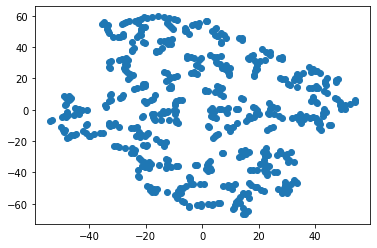

In [11]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=8, random_state=12).fit_transform(X)

x = [X_embedded[k][0] for k in range(len(X_embedded))]
y = [X_embedded[k][1] for k in range(len(X_embedded))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

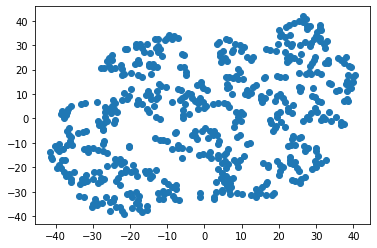

In [12]:
X_embedded1 = TSNE(n_components=2, perplexity=15).fit_transform(X)

x = [X_embedded1[k][0] for k in range(len(X_embedded))]
y = [X_embedded1[k][1] for k in range(len(X_embedded))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

In [13]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [270]:
af = AffinityPropagation(random_state=15, max_iter=1000).fit(X_embedded1)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
print(n_clusters_)
x_cluster_label = af.predict(X_embedded1)
while n_clusters_ > 7:
    af = AffinityPropagation(random_state=0).fit(X_embedded1[af.cluster_centers_indices_])
    center_cluster_labels = af.labels_
    x_cluster_label = af.predict(X_embedded1)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)
    clusters_centroids = af.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

18
4
cluster's centroids coordinates: 
 [[  5.8529077 -14.0458765]
 [ 25.389046   23.391527 ]
 [-28.354366  -22.022167 ]
 [-17.763762   17.834991 ]]


In [268]:
af = AffinityPropagation(random_state=0, max_iter=1000).fit(X)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
print(n_clusters_)
x_cluster_label = af.predict(X)
while n_clusters_ > 5:
    af = AffinityPropagation(random_state=0).fit(X[af.cluster_centers_indices_])
    center_cluster_labels = af.labels_
    x_cluster_label = af.predict(X)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)
    clusters_centroids = af.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

33
6
3
cluster's centroids coordinates: 
 [[-0.51148516  0.21541248  2.8550498   1.639824  ]
 [ 1.7011249  -1.2031103   0.93101454  1.9111269 ]
 [ 0.23244691 -2.4410856   3.2334692  -1.6141716 ]]


In [269]:
metrics.silhouette_score(X, x_cluster_label)

0.1731393

In [271]:
metrics.silhouette_score(X_embedded1, x_cluster_label)

0.43242744

In [16]:
dstrb_sub = pd.DataFrame(X_embedded1, index=labels, columns=[1, 2])
dstrb_sub['cluster_lab'] = x_cluster_label

In [17]:
cluster1 = dstrb_sub[dstrb_sub.cluster_lab==0]
cluster2 = dstrb_sub[dstrb_sub.cluster_lab==1]
cluster3 = dstrb_sub[dstrb_sub.cluster_lab==2]
cluster4 = dstrb_sub[dstrb_sub.cluster_lab==3]
assert(len(np.unique(list(cluster1.cluster_lab)))==1)
assert(len(np.unique(list(cluster2.cluster_lab)))==1)
assert(len(np.unique(list(cluster3.cluster_lab)))==1)
assert(len(np.unique(list(cluster4.cluster_lab)))==1)

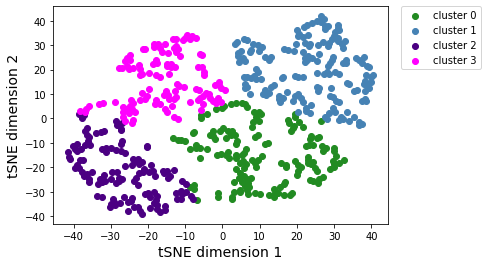

In [229]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[:2]]) for i in range(len(dstrb_sub))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.cluster_lab]):
    ix = np.where(dstrb_sub.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [19]:
central_1 = closest_distance(clusters_centroids[0], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 1 is {central_1}")
central_2 = closest_distance(clusters_centroids[1], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 2 is {central_2}")
central_3 = closest_distance(clusters_centroids[2], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 3 is {central_3}")
central_4 = closest_distance(clusters_centroids[3], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 4 is {central_4}")

Closest subject to centroid of cluster 1 is 173536
Closest subject to centroid of cluster 2 is 129634
Closest subject to centroid of cluster 3 is 766563
Closest subject to centroid of cluster 4 is 389357


### Creation of buckets dictionnary

In [20]:
bucket_path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rbuckets/'
suffix_path = '_normalized.bck'
buckets = {}
for sub in tqdm(list(labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    bucket = dtx.convert.bucket_aims_to_ndarray(bucket[0])
    buckets[sub] = bucket

100%|██████████| 550/550 [00:40<00:00, 13.65it/s]


In [21]:
subjects_c1 = cluster1.index
subjects_c2 = cluster2.index
subjects_c3 = cluster3.index
subjects_c4 = cluster4.index

buckets_c1 = {k: v for k,v in buckets.items() if k in list(subjects_c1)}
buckets_c2 = {k: v for k,v in buckets.items() if k in list(subjects_c2)}
buckets_c3 = {k: v for k,v in buckets.items() if k in list(subjects_c3)}
buckets_c4 = {k: v for k,v in buckets.items() if k in list(subjects_c4)}

#### Alignement of the subjects to respective central subject

In [22]:
aligned_buckets_C1, aligned_rot_C1, aligned_transl_C1 = ma.align_buckets_by_ICP_batch(buckets_c1, central_1)
aligned_buckets_C2, aligned_rot_C2, aligned_transl_C2 = ma.align_buckets_by_ICP_batch(buckets_c2, central_2)
aligned_buckets_C3, aligned_rot_C3, aligned_transl_C3 = ma.align_buckets_by_ICP_batch(buckets_c3, central_3)
aligned_buckets_C4, aligned_rot_C4, aligned_transl_C4 = ma.align_buckets_by_ICP_batch(buckets_c4, central_4)

>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 173536: 100%|██████████| 152/152 [00:01<00:00, 81.61it/s] 
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 129634: 100%|██████████| 159/159 [00:01<00:00, 112.74it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 766563: 100%|██████████| 123/123 [00:01<00:00, 81.48it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 389357: 100%|██████████| 116/116 [00:00<00:00, 118.07it/s]


In [23]:
def subj_count_extreme_coords(isodf, axis, min_coord, max_coord, num_coord=5):
    coord_values = np.linspace(min_coord, max_coord, num_coord)
    step = (coord_values[1] - coord_values[0])
    midpoint_min = coord_values[0] + step/2
    midpoint_max = coord_values[num_coord-1] - step/2
    coord_under = [elt for elt in isodf[axis] if elt<midpoint_min]
    coord_over = [elt for elt in isodf[axis] if elt>midpoint_max]
    num_subj_under = len(coord_under)
    num_subj_over = len(coord_over)
    return num_subj_under, num_subj_over

def get_MA_coords(isodf, axis, num_subj_threshold, num_coord=5):
    min_subj_coord = min(isodf[axis])
    max_subj_coord = max(isodf[axis])
    step = (max_subj_coord - min_subj_coord)/num_coord
    num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord, num_coord)
    while ((num_subj_under<num_subj_threshold)|(num_subj_over<num_subj_threshold)):
        step = (max_subj_coord - min_subj_coord)/num_coord
        if num_subj_under<num_subj_threshold:
            min_subj_coord = min_subj_coord + step
        if num_subj_over<num_subj_threshold:
            max_subj_coord = max_subj_coord - step
        num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    return np.linspace(min_subj_coord, max_subj_coord, num_coord)

### TSNE AXIS 1 analysis

In [34]:
MA_coords_1 = [dstrb_sub.loc[central_1][1]]
MA_coords_2 = [dstrb_sub.loc[central_2][1]]
MA_coords_3 = [dstrb_sub.loc[central_3][1]]
MA_coords_4 = [dstrb_sub.loc[central_4][1]]

#### Parameters

In [35]:
axis = 1

#### Cluster 1

In [197]:
SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(MA_coords_1, aligned_buckets_C1, cluster1, axis_n=axis, FWHM=100)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


In [253]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, threshold="88%", gblur_sigma=0.3, smoothRate=0.1, deciReductionRate=0)
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, 0, axis=0, scale=1)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_cluster_1.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 59.85it/s]


#### Cluster 2

In [75]:
SPAM_vols_c2, shift2 = ma.calc_MA_volumes_batch(MA_coords_2, aligned_buckets_C2, cluster2, axis_n=axis, FWHM=10)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


In [252]:
SPAM_meshes_2 = {}

for k, volume in tqdm(list(SPAM_vols_c2.items())[:]):
    SPAM_meshes_2[k]=dtx.convert.volume_to_mesh(
                    vol=volume,threshold="88%", gblur_sigma=0.20, smoothRate=0.1, deciReductionRate=0)
    
shifted_SPAM_meshes_2 = {}
for dist, mesh in SPAM_meshes_2.items():
    shifted_SPAM_meshes_2[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, 0, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_2.items()):
    aims.write(mesh, f"MA_cluster_2.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 59.62it/s]


#### Cluster 3

In [77]:
SPAM_vols_c3, shift3 = ma.calc_MA_volumes_batch(MA_coords_3, aligned_buckets_C3, cluster3, axis_n=axis, FWHM=10)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


In [251]:
SPAM_meshes_3 = {}

for k, volume in tqdm(list(SPAM_vols_c3.items())[:]):
    SPAM_meshes_3[k]=dtx.convert.volume_to_mesh(
                    vol=volume, threshold="88%", gblur_sigma=0.3, smoothRate=0.1, deciReductionRate=0)
    
shifted_SPAM_meshes_3 = {}
for dist, mesh in SPAM_meshes_3.items():
    shifted_SPAM_meshes_3[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, 0, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_3.items()):
    aims.write(mesh, f"MA_cluster_3.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 55.32it/s]


#### Cluster 4

In [87]:
SPAM_vols_c4, shift4 = ma.calc_MA_volumes_batch(MA_coords_4, aligned_buckets_C4, cluster4, axis_n=axis, FWHM=10)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


In [250]:
SPAM_meshes_4 = {}

for k, volume in tqdm(list(SPAM_vols_c4.items())[:]):
    SPAM_meshes_4[k]=dtx.convert.volume_to_mesh(
                    vol=volume, threshold="88%", gblur_sigma=0.3, smoothRate=0.1, deciReductionRate=0)
    
shifted_SPAM_meshes_4 = {}
for dist, mesh in SPAM_meshes_4.items():
    shifted_SPAM_meshes_4[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, 0, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_4.items()):
    aims.write(mesh, f"MA_cluster_4.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 56.31it/s]


### Visualisation of neighbours

In [158]:
def compute_distance(df_in, centroid):
    """Computes distance from centroid"""
    df_out = df_in
    df_out['distance'] = (df_out[1]-centroid[0])**2 + (df_out[2]-centroid[1])**2
    return df_out

In [192]:
distance = []
for i in cluster1.index:
    distance.append(np.linalg.norm(np.array(dstrb_sub.loc[i][:2])-clusters_centroids[0]))
cluster1['distance'] = distance
cluster1.sort_values(by='distance')[:4]

,1,2,cluster_lab,distance
170631,-8.639612,-28.082607,0,10.998600
146634,-7.644044,-29.088284,0,11.721991
190031,-7.751320,-27.323004,0,12.079824
145531,-6.897853,-33.389378,0,12.429374


In [193]:
distance = []
for i in cluster2.index:
    distance.append(np.linalg.norm(np.array(dstrb_sub.loc[i][:2])-clusters_centroids[1]))
cluster2['distance'] = distance
cluster2.sort_values(by='distance')[:4]

,1,2,cluster_lab,distance
882161,22.888109,25.721785,1,1.901549
129937,25.916182,26.259586,1,1.909100
694362,24.127649,24.774544,1,2.324148
105620,21.518116,27.020655,1,2.683797


In [194]:
distance = []
for i in cluster3.index:
    distance.append(np.linalg.norm(np.array(dstrb_sub.loc[i][:2])-clusters_centroids[2]))
cluster3['distance'] = distance
cluster3.sort_values(by='distance')[:4]

,1,2,cluster_lab,distance
140117,-38.423340,1.955594,2,12.665303
663755,-37.157543,1.349628,2,12.822507
168240,-37.723629,0.180110,2,14.104579
221218,-28.703478,-1.112995,2,15.582366


In [195]:
distance = []
for i in cluster4.index:
    distance.append(np.linalg.norm(np.array(dstrb_sub.loc[i][:2])-clusters_centroids[3]))
cluster4['distance'] = distance
cluster4.sort_values(by='distance')[:4]

,1,2,cluster_lab,distance
827052,-0.504600,6.613662,3,47.402002
480141,-1.629279,6.477765,3,48.209573
825654,-1.327522,8.194724,3,49.030942
100610,-2.415978,7.212763,3,49.280644


## Replication with model trained on HCP half 2

In [24]:
model_dir = '/neurospin/dico/lguillon/midl_22/new_design/half2/n_4_kl_2/'
model_2 = VAE((1, 20, 40, 40), 4, depth=3)
model_2.load_state_dict(torch.load(model_dir + 'checkpoint.pt'))
model_2 = model_2.to(device)

In [25]:
root_dir = '/neurospin/dico/lguillon/midl_22/new_design/analysis/model_2_n_4_kl_2/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model_2, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=4, depth=3, root_dir=root_dir)

In [26]:
results_2 = tester.test()
encoded_2 = {loader_name:[results_2[loader_name][k] for k in results_2[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
df_encoded_2 = pd.DataFrame()
df_encoded_2['latent'] = encoded_2['data']
X_2 = np.array(list(df_encoded_2['latent']))
labels_2 = list(results_2['data'].keys())

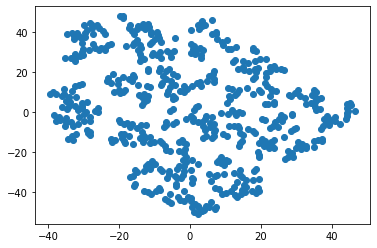

In [238]:
from sklearn.manifold import TSNE
X_embedded_2 = TSNE(n_components=2, perplexity=15).fit_transform(X_2)

x = [X_embedded_2[k][0] for k in range(len(X_embedded_2))]
y = [X_embedded_2[k][1] for k in range(len(X_embedded_2))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

In [29]:
af = AffinityPropagation(random_state=20, max_iter=1000).fit(X_embedded_2)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
print(n_clusters_)
x_cluster_label = af.predict(X_embedded_2)
while n_clusters_ > 7:
    af = AffinityPropagation(random_state=0).fit(X_embedded_2[af.cluster_centers_indices_])
    center_cluster_labels = af.labels_
    x_cluster_label = af.predict(X_embedded_2)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)
    clusters_centroids = af.cluster_centers_

21
4


In [239]:
dstrb_sub_2 = pd.DataFrame(X_embedded_2, index=labels_2, columns=[1, 2])
dstrb_sub_2['cluster_lab_half2'] = x_cluster_label
dstrb_sub_2['subjects'] = dstrb_sub_2.index

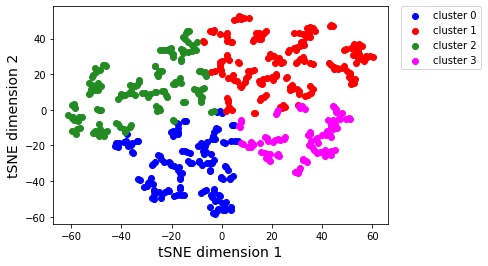

In [31]:
arr = np.array([np.array([dstrb_sub_2[k][i] for k in dstrb_sub_2.columns[:2]]) for i in range(len(dstrb_sub_2))])

color_dict = {0:'blue',1: 'red', 2:'forestgreen', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub_2.cluster_lab_half2]):
    ix = np.where(dstrb_sub_2.cluster_lab_half2 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [241]:
m1 = pd.merge(dstrb_sub, dstrb_sub_2, left_on=dstrb_sub.index, right_on=dstrb_sub_2.subjects)

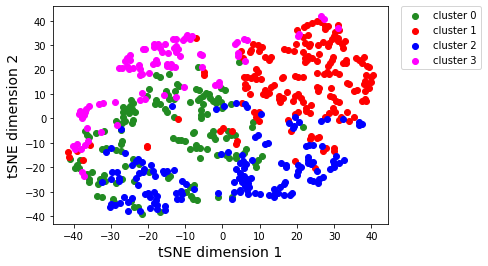

In [196]:
arr = np.array([np.array([m1[k][i] for k in m1.columns[1:3]]) for i in range(len(m1))])

color_dict = {0:'forestgreen',1: 'red', 2:'blue', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m1.cluster_lab_half2]):
    ix = np.where(m1.cluster_lab_half2 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [233]:
m1.head()

,key_0,1_x,2_x,cluster_lab,1_y,2_y,cluster_lab_half2,subjects
0,175136,6.962903,-26.369091,0,14.104691,-36.128517,2,175136
1,308129,-22.345957,21.936989,3,-37.297073,39.081779,3,308129
2,704238,3.740025,-20.824774,0,29.187534,-30.684566,2,704238
3,169141,-32.799442,-24.940620,2,-18.650368,-36.579739,0,169141
4,195445,-18.689825,22.340872,3,-16.372377,38.005486,3,195445


In [234]:
metrics.accuracy_score(m1.cluster_lab, m1.cluster_lab_half2)

0.5472727272727272

In [235]:
metrics.adjusted_rand_score(m1.cluster_lab, m1.cluster_lab_half2)

0.3624866033734658

In [273]:
metrics.balanced_accuracy_score(m1.cluster_lab_half2, m1.cluster_lab)

0.5481331720731915

In [275]:
metrics.rand_score(m1.cluster_lab_half2,m1.cluster_lab,)

0.7562775293922835

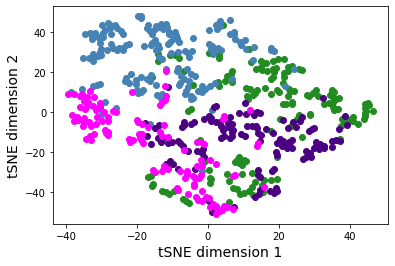

In [244]:
arr = np.array([np.array([m1[k][i] for k in m1.columns[4:6]]) for i in range(len(m1))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m1.cluster_lab]):
    ix = np.where(m1.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()